In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as pyo
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz

In [12]:
df = pd.read_csv('merged_df.csv')

def _compute_vd_helper(volume: float, taker_buy_volume: float) -> float:
    
    vd = 2*taker_buy_volume - volume
    return vd

df['volume_delta_base_asset'] = df.apply(lambda x: _compute_vd_helper(x.volume,
                                         x.taker_buy_base_asset_volume), axis=1)

df['returns'] = (df.close - df.open)/df.open
df['algo_funding'] = 100 * df['fundingRate']

gain = pd.Series([1 if val > 0 else 0 for val in df.returns])

In [13]:
"How to code a decision tree from a pandas dataframe"
# Set the percentage of training data
train_data_percentage = 0.5

# Prepare your feature matrix and target variable
X = df[['volume', 'algo_funding', 'volume_delta_base_asset']].shift(periods=-1)
X = X.drop(X.index[-1])
X = X.drop(X.index[0])

# Target variable
y = gain
y = y.drop(y.index[-1])
y = y.drop(y.index[0])

# Split the data into training and testing sets

# Calculate the number of samples for training based on the percentage
num_train_samples = int(train_data_percentage * len(X))

# Split the data into training and testing sets
X_train = X[:num_train_samples]
X_test = X[num_train_samples:]
y_train = y[:num_train_samples]
y_test = y[num_train_samples:]

# Initialize the decision tree classifier
clf = DecisionTreeClassifier(max_depth=3)

# Train the decision tree classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Visualize the tree structure
dot_data = tree.export_graphviz(clf)
graph = graphviz.Source(dot_data)
graph.render('decision_tree', format='jpeg')
graph.view()  # Display the visualization

/tmp/ipykernel_38686/1217255505.py:23: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_38686/1217255505.py:24: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



'decision_tree.pdf'

In [16]:
df = df[-len(X_test):]
df = df.reset_index(drop=True)

weak_buy = lambda row: 1 if (row.algo_funding < -0.003
                             and row.volume_delta_base_asset > -4950.871) else 0

df['weak_buy'] = df.apply(weak_buy, axis=1).shift(1)

# create subplots with two y-axes
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Candlestick(
    x=pd.to_datetime(df['open time'], unit='ms'),
    open=df.open,
    high=df.high,
    low=df.low,
    close=df.close,
    increasing=dict(line=dict(color='green')),
    decreasing=dict(line=dict(color='red')),
    name='Price')
)

fig.add_trace(go.Scatter(
    x=pd.to_datetime(df['open time'][df.weak_buy > 0], unit='ms'),
    y=-3000+df.low[df.weak_buy > 0],
    name='weak buy',
    mode='markers',
    marker=dict(
        symbol='triangle-up',
        size=10,
        color='blue',
        line=dict(width=1, color='blue'),
    )
))

pio.write_image(fig, 'trade_entries_chart.jpeg', format='png')
pyo.plot(fig, filename='plot.html', auto_open=True)

'plot.html'

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



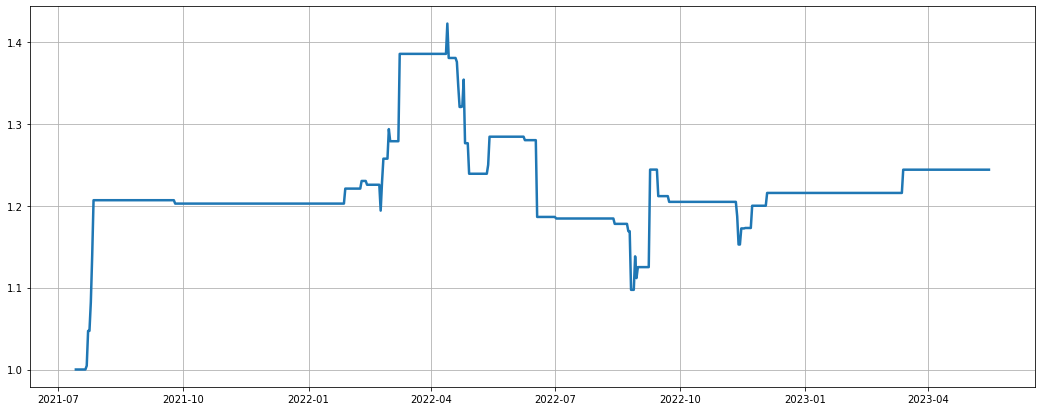

In [17]:
# Create a new column for the equity curve
df['equity_curve'] = 1.0  # Initial value of 1.0

# Iterate through the DataFrame rows
for i in range(1, len(df)):
    # Compute equity curve based on buy signals and percentage returns
    if df.weak_buy.iloc[i] == 1:
        df.equity_curve.at[i] = df.equity_curve.iloc[i-1] * (1 + df.returns.iloc[i])
    else:
        df.equity_curve.at[i] = df.equity_curve.iloc[i-1]

# Create a larger figure
plt.figure(figsize=(18, 7))  # Set the width to 8 inches and height to 6 inches
plt.grid(True)
plt.plot(pd.to_datetime(df['open time'], unit='ms'), df.equity_curve, linewidth=2.5)
plt.savefig('equity_curve.png')

In [19]:
import numpy as np


def calculate_returns(equity_curve: np.array) -> np.array:

    returns = np.diff(equity_curve)/equity_curve[:-1]

    return returns


def calculate_max_drawdown(equity_curve: np.array) -> np.array:
    
    m_max = 0.
    maxDD = 0.

    for i in range(equity_curve.shape[0]):
        m_max = max(m_max, equity_curve[i])
        maxDD = min(maxDD, equity_curve[i]/m_max - 1)

    return round(maxDD, 3)


def calculate_sharpe(returns: np.array) -> np.array:
    
    gap = 1./24
    mean = returns.mean()
    std = returns.std()

    sharpe = round(mean / std * np.sqrt(365/gap), 2) if std != 0 else 0

    return sharpe


def calculate_sortino(returns: np.array) -> np.array:
    
    gap = 1./24
    mean = returns.mean()
    downside = (np.square(returns[returns < 0])).sum()
    downside_dev = np.sqrt(downside/returns.size)

    sortino = round(mean / downside_dev * np.sqrt(365/gap), 2)\
        if downside_dev != 0 else 0

    return sortino


def calculate_omega(returns: np.array) -> np.array:

    positive_area = returns[returns > 0].sum()
    negative_area = -returns[returns < 0].sum()

    omega = round(positive_area / negative_area, 2)\
        if negative_area != 0 else 0

    return omega


def get_stats(equity_curve: np.array) -> dict:
    """Calculate important stats of a strategy and return them in a dict.

    Parameters
    ----------
    equity_curve : np.array
        The equity curve of the strategy.

    Returns
    -------
    dict
        Dictionary containing the stats of the strategy.
    """

    returns = calculate_returns(equity_curve)
    mean = returns.mean()
    std = returns.std()
    max_dd = calculate_max_drawdown(equity_curve)
    sharpe = calculate_sharpe(returns)
    sortino = calculate_sortino(returns)
    omega = calculate_omega(returns)

    return {'returns': returns, 'mean': mean, 'std': std,
            'max_dd': max_dd, 'sharpe': sharpe,
            'sortino': sortino, 'omega': omega}


def print_stats(equity_curve: np.array) -> None:
    """Calculate and print important stats of the strategy.

    Parameters
    ----------
    equity_curve : np.array
        The equity curve of the strategy.
    """

    stats = get_stats(equity_curve)

    print('Mean:            {:.2%}'.format(stats['mean']))
    print('Standard Deviation: {:.2%}'.format(stats['std']))
    print('Max Drawdown:    {:.2%}'.format(stats['max_dd']))
    print('Sharpe Ratio:    {:.2f}'.format(stats['sharpe']))
    print('Sortino Ratio:   {:.2f}'.format(stats['sortino']))
    print('Omega Ratio:     {:.2f} '.format(stats['omega']))

print_stats(df.equity_curve)

Mean:            0.04%
Standard Deviation: 0.89%
Max Drawdown:    -22.80%
Sharpe Ratio:    3.83
Sortino Ratio:   6.55
Omega Ratio:     1.54 
